# Installing Dependencies:

In [1]:
# !apt-get install -y xvfb python-opengl > /dev/null 2>&1
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# !pip install gym[classic_control]
# !apt-get update > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1
!pip install gymnasium
!pip install numpy
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 3.7 MB/s eta 0:00:00


# Importing Dependencies

In [2]:
import random
import matplotlib
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gymnasium as gym

# Defining Helper Functions

In [3]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

#Create a gym environment and reset the environment.


In [4]:
env = gym.make("CartPole-v1")
print(env.reset())

(array([ 0.04888949, -0.01169159, -0.03672704, -0.03882843], dtype=float32), {})


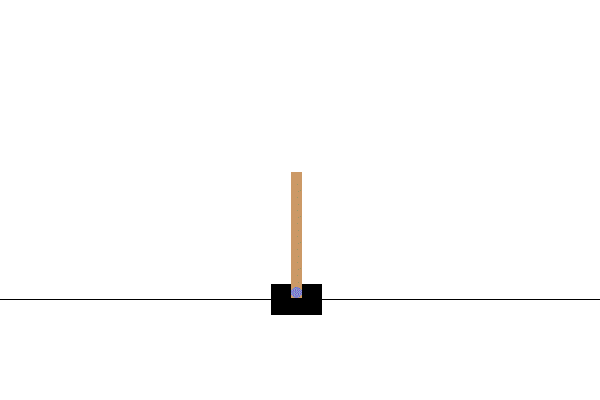

#Print out the action space.

In [5]:
print(env.action_space.n)

2


From here, we can see that there is two valid action space.

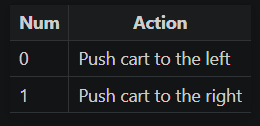

#Print out the observation space.

In [6]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


From the above output, the first two lists are the min and max values of the 4 observed values:

(cart positon, cart velocity, pole angle and pole angular velocity)

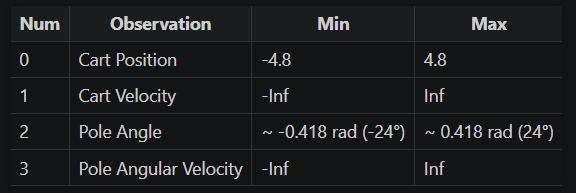

In [7]:
#Learning rate
alpha = 0.1
#Discount factor
gamma = 0.99
episode = 10000
epsilon = 0.2
lowerBound = env.observation_space.low
upperBound = env.observation_space.high
#Instead of using inf, set upper and lower bound for cart velocity and pole angular velocity
lowerBound[1] = -4
lowerBound[3] = -10
upperBound[1] = 4
upperBound[3] = 10
bin = [20,20,20,20]

Since the observation space in the cartpole system is continuous,

S=(cart positon, cart velocity, pole angle and pole angular velocity),

They can take any values in the continuous intervals determined by the limits of the observation space, resulting in an infiinite number of states.

To use the q learning algorithm, we need to approximate a continuous state space by a finite discrete state space. We do that by discretise each state variable.



In [8]:
def get_discrete_state(state):
  cart_position = state[0]
  cart_velocity = state[1]
  pole_angle = state[2]
  pole_angular_velocity = state[3]

  cartpositionBin =  np.linspace(lowerBound[0], upperBound[0], bin[0])
  velocityBin = np.linspace(lowerBound[1], upperBound[1], bin[1])
  poleAngleBin = np.linspace(lowerBound[2], upperBound[2], bin[2])
  poleAngularVelocityBin = np.linspace(lowerBound[3], upperBound[3], bin[3])

  p = np.maximum(np.digitize(state[0], cartpositionBin)-1,0)
  v = np.maximum(np.digitize(state[1], velocityBin)-1,0)
  a = np.maximum(np.digitize(state[2], poleAngleBin)-1,0)
  av = np.maximum(np.digitize(state[3], poleAngularVelocityBin)-1,0)
  return tuple([p,v,a,av])

In [9]:
actions = env.action_space.n
qtable = np.random.uniform(low = 0, high = 1, size=(bin[0],bin[1],bin[2],bin[3], actions))
sumRewards=[]

##Select an action

In [10]:
def selectAction(state, current_episode, epsilon):
  #For the first 500 episodes, to ensure enough explorations
  if current_episode < 500:
    return (np.random.choice(actions))
  #Generate a random number betwen [0.0, 1.0) to compare with the epsilon value
  randomNumber = np.random.random()
  if current_episode > 3000:
    epsilon = 0.999 * epsilon
  #Select random actions if the random value is less than the epsilon
  if randomNumber < epsilon:
    return np.random.choice(actions)
  #Greedy action, return max
  else:
    return np.random.choice(np.where(qtable[get_discrete_state(state)] == np.max(qtable[get_discrete_state(state)]))[0])

In [11]:
def train(alpha, gamma, episodes, epsilon):
  env = gym.make("CartPole-v1")
  for ep in range(episodes + 1):
    rewards_per_episode =[]

    #reset the environment
    (stateS,_) = env.reset()
    stateS = list(stateS)
    print("Simulating episode {}".format(ep))
    terminated = False

    while not terminated:
      discretizedState = get_discrete_state(stateS)
      action = selectAction(stateS, ep, epsilon)
      (Sprime, reward, terminated,_,_) = env.step(action)
      rewards_per_episode.append(reward)
      Sprime = list(Sprime)
      discretizedSprime = get_discrete_state(Sprime)
      #Return the max value
      Qmaxprime = np.max(qtable[discretizedSprime])

      if not terminated:
        qtable[discretizedState + (action,)] = qtable[discretizedState + (action,)] + alpha * (
                    reward + gamma*Qmaxprime -qtable[discretizedState + (action,)])
      else:
          qtable[discretizedState + (action,)] = qtable[discretizedState + (action,)] + alpha * (
                    reward + 0 -qtable[discretizedState + (action,)])
      stateS = Sprime
    print("Sum of rewards {}".format(np.sum(rewards_per_episode)))
    sumRewards.append(np.sum(rewards_per_episode))

In [12]:
train(alpha, gamma, episode, epsilon)

Streaming output truncated to the last 5000 lines.
Simulating episode 7501
Sum of rewards 170.0
Simulating episode 7502
Sum of rewards 171.0
Simulating episode 7503
Sum of rewards 244.0
Simulating episode 7504
Sum of rewards 96.0
Simulating episode 7505
Sum of rewards 116.0
Simulating episode 7506
Sum of rewards 22.0
Simulating episode 7507
Sum of rewards 165.0
Simulating episode 7508
Sum of rewards 211.0
Simulating episode 7509
Sum of rewards 104.0
Simulating episode 7510
Sum of rewards 87.0
Simulating episode 7511
Sum of rewards 197.0
Simulating episode 7512
Sum of rewards 193.0
Simulating episode 7513
Sum of rewards 221.0
Simulating episode 7514
Sum of rewards 98.0
Simulating episode 7515
Sum of rewards 169.0
Simulating episode 7516
Sum of rewards 151.0
Simulating episode 7517
Sum of rewards 149.0
Simulating episode 7518
Sum of rewards 236.0
Simulating episode 7519
Sum of rewards 162.0
Simulating episode 7520
Sum of rewards 166.0
Simulating episode 7521
Sum of rewards 108.0
Simulati

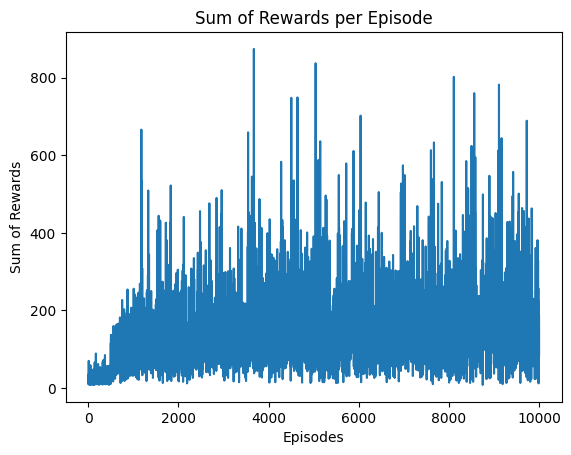

In [13]:
plt.plot(sumRewards)
plt.title('Sum of Rewards per Episode')
plt.xlabel('Episodes')
plt.ylabel('Sum of Rewards')
plt.show()

In [14]:
print(qtable)

[[[[[3.98470613e-01 1.14995597e-01]
    [1.53596782e-01 2.56629543e-01]
    [2.32171597e-01 4.67711013e-01]
    ...
    [9.98572425e-01 2.06434380e-01]
    [5.72499406e-01 4.05898023e-01]
    [1.35693021e-01 1.21492262e-01]]

   [[6.43714334e-01 9.13751412e-01]
    [5.05837250e-01 3.46033724e-02]
    [8.98078274e-01 7.04327379e-01]
    ...
    [2.70218865e-01 3.11056952e-01]
    [2.24201757e-01 9.20201849e-01]
    [1.16624688e-01 8.67080916e-01]]

   [[1.45059981e-01 9.79464232e-01]
    [1.49348960e-01 5.95886877e-01]
    [7.23971261e-01 6.64970304e-01]
    ...
    [1.73894758e-01 8.89591255e-01]
    [5.47841083e-01 1.11510814e-01]
    [6.27850014e-01 1.00934551e-01]]

   ...

   [[4.63285098e-01 4.46220965e-01]
    [4.96599043e-01 8.82527877e-01]
    [7.89155112e-01 2.94121788e-01]
    ...
    [5.87683490e-01 8.60971448e-01]
    [3.54221185e-01 4.27434807e-01]
    [4.41852785e-01 5.01760190e-01]]

   [[9.64778009e-01 4.39502264e-01]
    [9.56266724e-01 4.38238879e-01]
    [7.90835275e

## Demonstrating the effectiveness of the RL agent

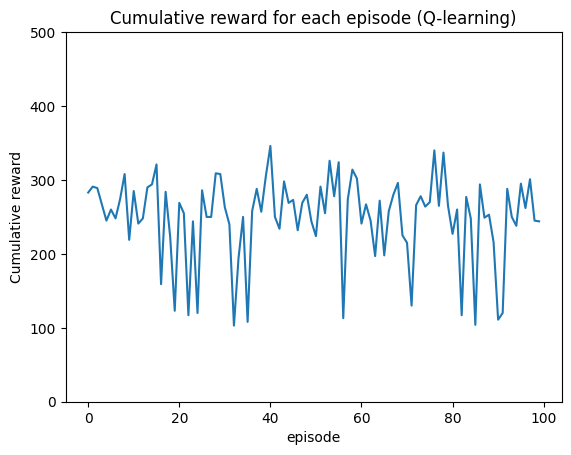

Average cumulative reward: 249.3
Is my agent good enough? Good enough
Mininum is: 103.0
Maximum is: 346.0


In [22]:
def demo(qtable):
    env = gym.make("CartPole-v1")

    episode_rewards = []

    for episode in range(100):
        state = env.reset()[0]
        episode_reward = 0
        terminated = False

        while not terminated:
            # Choose action using Q-table
            action = np.argmax(qtable[get_discrete_state(state)])

            # Take action and observe new state and reward
            next_state, reward, terminated, _ ,_= env.step(action)

            state = next_state
            episode_reward += reward

        episode_rewards.append(episode_reward)
    return episode_rewards

episode_rewards = demo(qtable)
plt.plot(episode_rewards)
plt.title('Cumulative reward for each episode (Q-learning)')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.ylim(0,500)
plt.show()
print("Average cumulative reward:", np.mean(episode_rewards))
print("Is my agent good enough?", "Good enough" if np.mean(episode_rewards) > 195 else "Train again")
print("Mininum is: " +np.min(episode_rewards).astype(str))
print("Maximum is: "+np.max(episode_rewards).astype(str))

## Random Policy
From the result of the random policy, we can see that our trained agent performed much better.

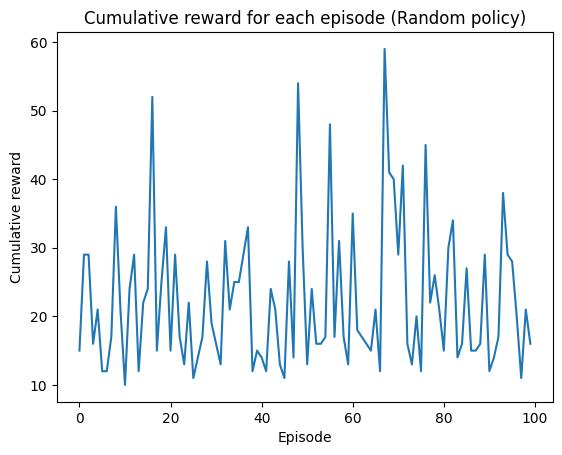

Average cumulative reward: 22.29
Is my agent good enough? False
Mininum is: 10.0
Maximum is: 59.0


In [16]:
def randomPolicy():
    env = gym.make("CartPole-v1")
    episode_rewards = []

    for episode in range(100):
        state = env.reset()[0]
        episode_reward = 0
        terminated = False

        while not terminated:
            # Choose action randomly
            action = np.random.choice(actions)

            # Take action and observe new state and reward
            next_state, reward, terminated, _ ,_= env.step(action)

            state = next_state
            episode_reward += reward

        episode_rewards.append(episode_reward)
    return episode_rewards
episode_rewards = randomPolicy()
plt.plot(episode_rewards)
plt.title('Cumulative reward for each episode (Random policy)')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()
print("Average cumulative reward:", np.mean(episode_rewards))
print("Is my agent good enough?", np.mean(episode_rewards) > 195)
print("Mininum is: " +np.min(episode_rewards).astype(str))
print("Maximum is: "+np.max(episode_rewards).astype(str))